---
title: "fit"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In [1]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

# %matplotlib widget

In [2]:
#| code-summary: "load data from csv"
df = pd.read_csv('greenhouse_cooling.csv', index_col='time', parse_dates=True)
df

,T_in,T_out
time,,
2023-06-24 23:30:00,13.8,16.6
2023-06-24 23:40:00,14.1,16.4
2023-06-24 23:50:00,14.0,16.4
2023-06-25 00:00:00,14.6,16.4
2023-06-25 00:10:00,14.2,16.3
...,...,...
2023-07-08 04:30:00,13.9,19.2
2023-07-08 04:40:00,13.2,18.8
2023-07-08 04:50:00,13.9,18.7


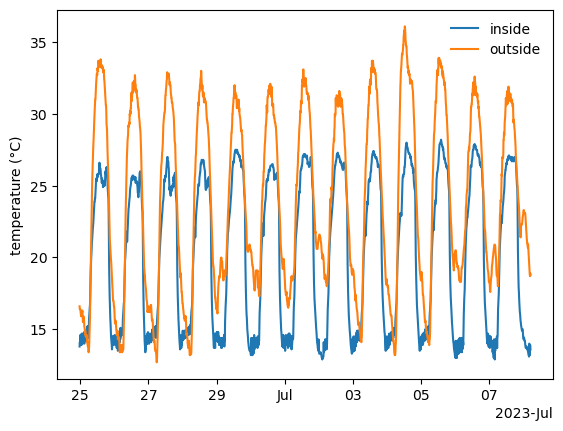

In [8]:
#| code-summary: "plot temperatures"
fig, ax = plt.subplots(sharex=True)

ax.plot(df['T_in'], c='tab:blue', label='inside')
ax.plot(df['T_out'], c='tab:orange', label='outside')
ax.set(ylabel='temperature (°C)')

# formating dates on x axis
locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.legend(frameon=False)

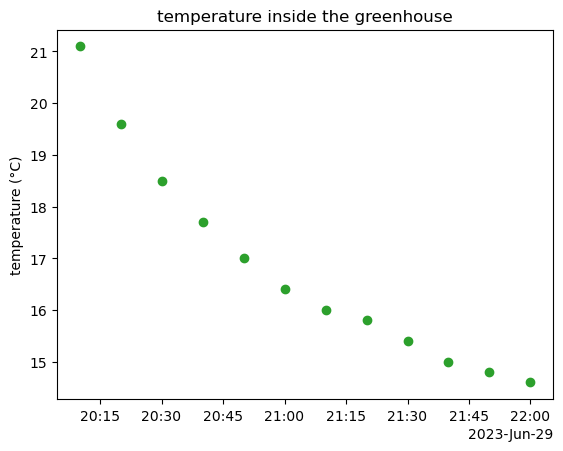

In [19]:
#| code-summary: "chose one evening, plot it"

df_fit = df['2023-06-29 20:10:00':'2023-06-29 22:00:00']

fig, ax = plt.subplots(sharex=True)

ax.scatter(df_fit['T_in'].index, df_fit['T_in'], color='tab:green')
ax.set(ylabel='temperature (°C)',
       title="temperature inside the greenhouse")

# formating dates on x axis
locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

In [21]:
#| code-summary: "linear fit"

df_fit['minutes'] = (df_fit.index - df_fit.index[0]).total_seconds() / 60
# linear Fit (degree 1)
degree = 1
coeffs = np.polyfit(df_fit['minutes'], df_fit['T_in'], degree)
# linear Function
linear_function = np.poly1d(coeffs)
print(f"starting at {coeffs[1]:.2f} degrees, the temperature decreases by {-coeffs[0]:.2f} degrees every minute.")

starting at 19.80 degrees, the temperature decreases by 0.05 degrees every minute.


/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_26375/2475866714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit['minutes'] = (df_fit.index - df_fit.index[0]).total_seconds() / 60


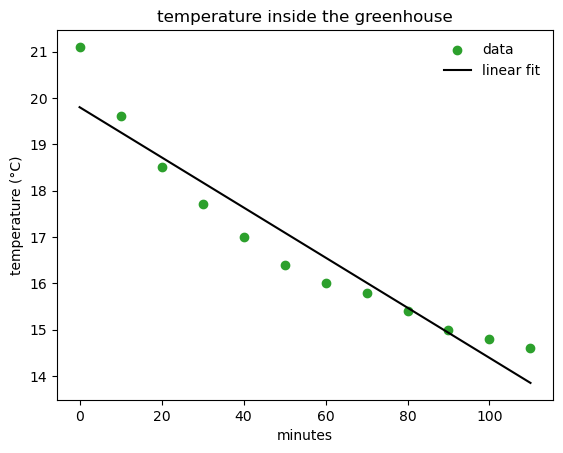

In [23]:
#| code-summary: "see result of linear fit"

fig, ax = plt.subplots(sharex=True)

ax.scatter(df_fit['minutes'], df_fit['T_in'],
           color='tab:green', label='data')
ax.plot(df_fit['minutes'], linear_function(df_fit['minutes']),
        color='black', label='linear fit')

ax.set(xlabel='minutes',
       ylabel='temperature (°C)',
       title="temperature inside the greenhouse")

ax.legend(frameon=False)

In [24]:
def cooling(t, T_env, T0, r):
    return T_env + (T0 - T_env)*np.exp(-r*t)

In [27]:
t = df_fit['minutes'].values
y = df_fit['T_in'].values

T_init = df_fit['T_in'][0]

popt, pcov = curve_fit(f=cooling,             # model function
                     xdata=t,                 # x data
                     ydata=y,                 # y data
                     p0=(2, T_init, 0.5),     # initial guess of the parameters
                     )
print(f"the optimal parameters are {popt}")

the optimal parameters are [14.01663586 21.0074623   0.02121802]


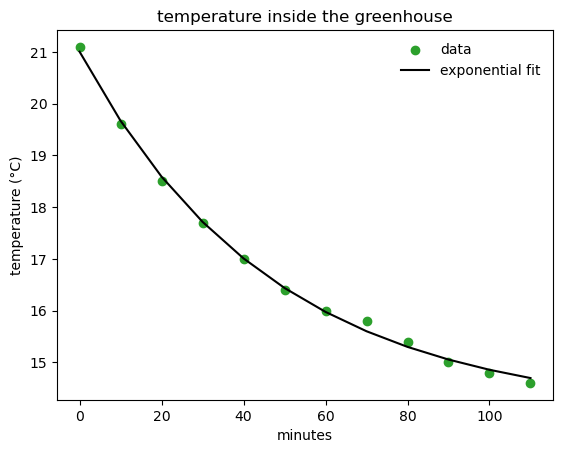

In [29]:
#| code-summary: "see result of linear fit"

fig, ax = plt.subplots(sharex=True)

ax.scatter(df_fit['minutes'], df_fit['T_in'],
           color='tab:green', label='data')
ax.plot(t, cooling(t, *popt),
        color='black', label='exponential fit')

ax.set(xlabel='minutes',
       ylabel='temperature (°C)',
       title="temperature inside the greenhouse")

ax.legend(frameon=False)

Let's write a function that executes the fit and returns two of the fitted parameters: `T_env` and `r`.

In [30]:
def run_fit(data):
    data['minutes'] = (data.index - data.index[0]).total_seconds() / 60
    t = data['minutes'].values
    y = data['T_in'].values
    T_init = data['T_in'][0]
    popt, pcov = curve_fit(f=cooling,             # model function
                        xdata=t,              # x data
                        ydata=y,              # y data
                        p0=(2, T_init, 0.5),   # initial guess of the parameters
                        )
    return popt[0],popt[2]

We now apply this function to several consecutive evenings, and we keep the results in a new dataframe.

In [31]:
df_night = df.between_time('20:01', '22:01', inclusive='left')

# Group by day and apply the function
result_series = df_night.groupby(df_night.index.date).apply(run_fit)

# Convert the series to a dataframe if needed
result_df = pd.DataFrame(result_series.tolist(), index=result_series.index, columns=['T_env', 'r'])
result_df.index = pd.to_datetime(result_df.index)
result_df

,T_env,r
2023-06-25,13.275540,0.019354
2023-06-26,13.331949,0.027034
2023-06-27,13.254827,0.018753
2023-06-28,13.392919,0.020449
2023-06-29,14.016636,0.021218
2023-06-30,13.807517,0.021749
2023-07-01,14.994207,0.023504
2023-07-02,14.314220,0.023705
2023-07-03,14.585848,0.019438
2023-07-04,14.377220,0.019504


[(19.0, 24.0), Text(0, 0.5, 'outside temperature')]

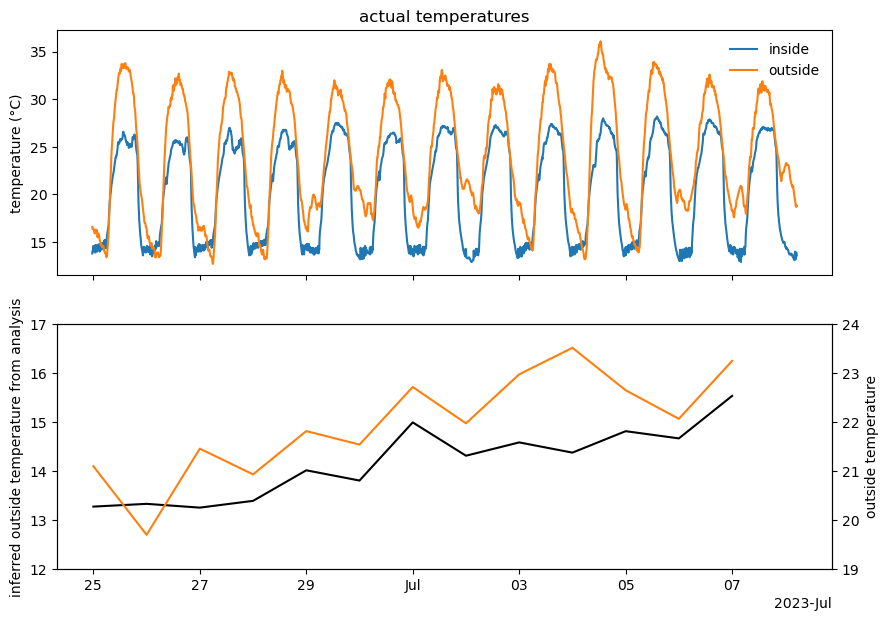

In [42]:
fig, ax = plt.subplots(2,1,sharex=True, figsize=(10,7))

ax[0].plot(df['T_in'], c='tab:blue', label='inside')
ax[0].plot(df['T_out'], c='tab:orange', label='outside')
ax[0].set(ylabel='temperature (°C)',
          title="actual temperatures")

# formating dates on x axis
locator = mdates.AutoDateLocator(minticks=7, maxticks=11)
formatter = mdates.ConciseDateFormatter(locator)
ax[0].xaxis.set_major_locator(locator)
ax[0].xaxis.set_major_formatter(formatter)

ax[0].legend(frameon=False)

ax[1].plot(result_df['T_env'], color='black')
# ax[1].plot(df_night['T_out'].resample('D').mean(), c='m')
ax2 = ax[1].twinx()
ax2.plot(df_night['T_out'].resample('D').mean(), color='tab:orange')
ax[1].set(ylim=[12, 17],
          ylabel='outside temperature inferred from analysis')
ax2.set(ylim=[19, 24],
        ylabel="outside temperature")